<a href="https://colab.research.google.com/github/bpriantti/projeto_ml_clustering_de_indicadores_de_timming_para_estrategia_de_quant_trading./blob/main/Projeto_ML_Clustering_de_Indicadores_de_Timming_para_estrategia_de_Quant_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### non-native libs:

In [1]:
!pip install -q yfinance
!pip install -q talib-binary

     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 2.4 MB 7.6 MB/s 


### import libs:

In [2]:
#import libs:
import pandas as pd
import numpy as np

#libs para visualization dos dados:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

#---:
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as Dash
from plotly.subplots import make_subplots

#lib para api com ativos da bolsa:
import yfinance as yf
import talib as ta

#---
import warnings
warnings.filterwarnings("ignore")

### database download:

In [3]:
database = yf.download('PETR4.SA', '2005-1-1','2022-12-31')

[*********************100%***********************]  1 of 1 completed


### wralling:

In [4]:
database['Open']  = database.Open * database['Adj Close']/database['Close']
database['High']  = database.High * database['Adj Close']/database['Close']
database['Low']   = database.Low  * database['Adj Close']/database['Close']
database['Close'] = database['Adj Close']

del database['Adj Close']
database.dropna(inplace=True)

database.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-01-03,4.438507,4.456716,4.287826,4.288280,30044800
2005-01-04,4.324242,4.352011,4.233651,4.237293,37667200
2005-01-05,4.247310,4.287370,4.179025,4.220906,30873600
2005-01-06,4.243667,4.256413,4.183576,4.233652,28224000
2005-01-07,4.242301,4.292832,4.211346,4.252316,25980800


### visualization:

In [5]:
fig = go.Figure()
    
fig.add_trace(go.Candlestick(
              x=database.index,
              open  = database['Open'], 
              high  = database['High'],
              low   = database['Low'], 
              close = database['Close']))

fig.update_layout()
fig.update_layout(width = 1000
                 ,template = 'plotly_dark'
                 ,title = 'PETR4- 2005 to 2020: '
                 ,xaxis_rangeslider_visible=False)
fig.show()

### calc indicators:

In [6]:
database['adx']         = ta.ADX(database['High'],database['Low'],database['Close'],14)
database['pos_dir_mov'] = ta.PLUS_DI(database['High'],database['Low'],database['Close'],14)
database['neg_dir_mov'] = ta.MINUS_DI(database['High'],database['Low'],database['Close'],14)

database['target_var'] = database['Close'].pct_change(2).shift(-2)
database.dropna(inplace=True)

In [7]:
database.loc[:,'adx':].head()

,adx,pos_dir_mov,neg_dir_mov,target_var
Date,,,,
2005-02-14,24.706889,32.490634,16.227819,0.006382
2005-02-15,24.465875,30.662507,19.880356,0.016328
2005-02-16,24.554715,31.249120,18.467224,0.001951
2005-02-17,25.248861,35.362319,17.310050,0.012658
2005-02-18,25.246288,33.611252,20.075336,0.020448


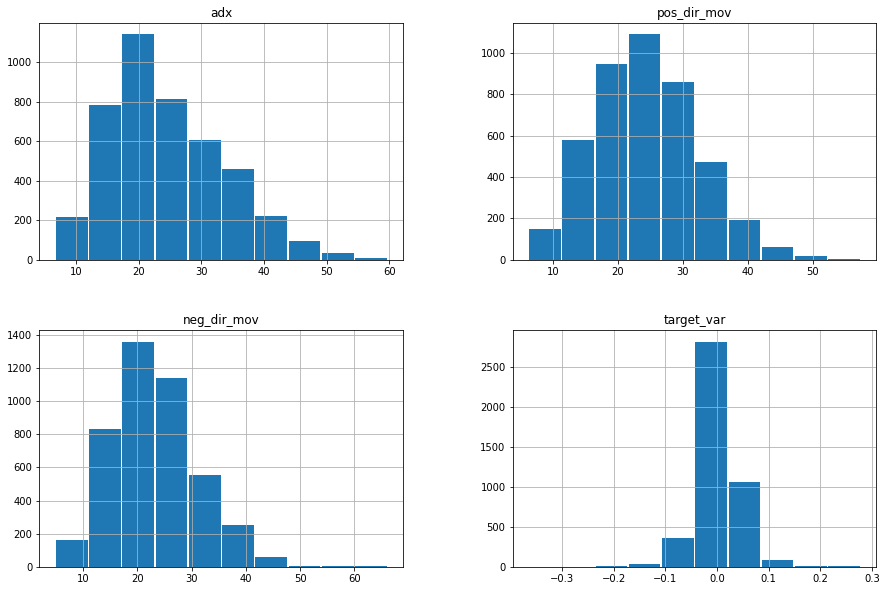

In [8]:
#visualization:
database.loc[:,'adx':].hist(figsize = (15,10), rwidth = 0.95);

### train-test split:

In [9]:
#data train-test split:
data_train = database.loc['2005-02-14':'2012-12-31']
data_test = database.loc['2013-01-01':]

#features x, train-test:
x_train = data_train.loc[:,'adx':'neg_dir_mov']
x_test = data_test.loc[:,'adx':'neg_dir_mov']

### clustering:

In [10]:
from math import sqrt
from sklearn.cluster import KMeans

#verificar se é necessario normalizar as bases!
k = x_train
min_clusters = 2
max_clusters = 20
inertias = np.zeros(shape = (max_clusters - min_clusters + 1,))

for i in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters = i, random_state = 1)
    kmeans.fit(k)
    inertias[i - min_clusters] = kmeans.inertia_

#plot elbow method:
fig = make_subplots(rows = 1, cols = 1,
                    shared_xaxes = True,
                    vertical_spacing = 0.08)

fig.add_trace(go.Scatter(x = list(range(2,30))
                         , y = inertias
                         , line = dict(color = "blue"))
                         , row = 1, col = 1)

fig.update_layout(  height=500, width=800
                  , title_text = "Elbow Method: "
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "n clusters"
                  , legend_title = "Study objects"
                  , font = dict(size = 12, color = "Black")
                 )

fig.update_layout(hovermode = "x")

fig.show()

#### treinando modelo:

In [18]:
kmodel = KMeans(n_clusters = 5, random_state = 1)
clusters = kmodel.fit(k)

data_train['clusters'] = clusters.labels_

In [19]:
data_train

,Open,High,Low,Close,Volume,adx,pos_dir_mov,neg_dir_mov,target_var,clusters
Date,,,,,,,,,,
2005-02-14,4.648369,4.666123,4.621511,4.636533,29689600,24.706889,32.490634,16.227819,0.006382,1
2005-02-15,4.571889,4.629704,4.556867,4.600114,44016000,24.465875,30.662507,19.880356,0.016328,1
2005-02-16,4.613772,4.668855,4.568249,4.666123,90828800,24.554715,31.249120,18.467224,0.001951,1
2005-02-17,4.691615,4.753981,4.675226,4.675226,56451200,25.248861,35.362319,17.310050,0.012658,1
2005-02-18,4.688883,4.693436,4.625606,4.675226,28630400,25.246288,33.611252,20.075336,0.020448,1
...,...,...,...,...,...,...,...,...,...,...
2012-12-20,9.671164,9.810184,9.559948,9.754576,25639600,25.769887,28.990132,13.853880,-0.047031,1
2012-12-21,9.573853,9.610925,9.448735,9.587755,29390200,25.761417,26.578280,15.726540,-0.061866,1
2012-12-26,9.518244,9.583119,9.268007,9.295811,24075000,24.755271,24.301935,19.220528,-0.026919,1


#### verificando mapa clusters:

In [20]:
df = data_train.loc[:,'adx':]

fig = px.scatter_3d(df, x='pos_dir_mov', y='neg_dir_mov', z='adx',
                    color='clusters',height=500, width=800, title = 'Clusters Plot: ')

fig.update_layout(margin=dict(l=10, r=10, t=50, b=10))

fig.show()

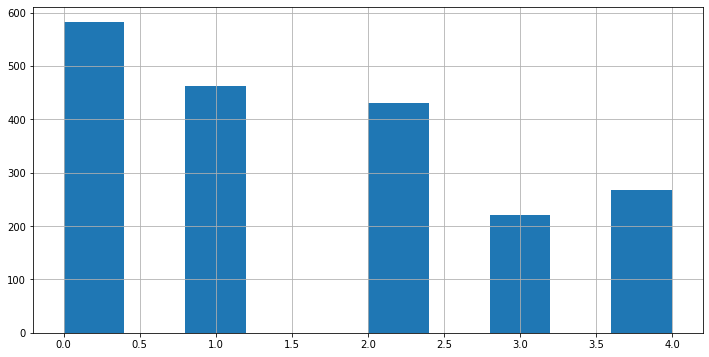

In [21]:
data_train['clusters'].hist(figsize = (12,6))

#### analise bivariada:

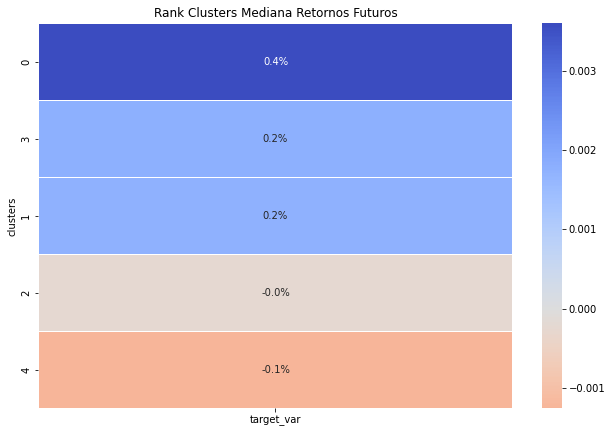

In [22]:
#acessando os clusters
data_train['clusters'] = clusters.labels_

#rank por mediana:
rank = data_train[['target_var','clusters']].groupby(['clusters']).median()
rank.sort_values(by = ['target_var'], ascending = False)*100

#plot:
cmap = sns.diverging_palette(10, 133, as_cmap=True)
g = sns.heatmap(data= rank.sort_values(by = ['target_var'], ascending = False), cmap='coolwarm_r',cbar=True,linewidths=.1,annot=True,fmt=".1%",annot_kws={'rotation':0},center=0.00,xticklabels=True)
g.figure.set_size_inches(w=27/2.54, h=18/2.54)
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 10)
g.set_title('Rank Clusters Mediana Retornos Futuros')
plt.show();

### predict base de teste:

#### atribuido clusters:

In [23]:
#---:
clusters = kmodel.predict(x_test)

# atribuindo clusters a base de teste:
data_test['clusters'] = clusters

#### visualization:

In [24]:
fig = px.histogram(data_test['target_var'],height=500, width=800,title = 'Retorno em 2 dias futuros: ')

fig.layout.xaxis.title = 'Target_Var'
fig.layout.yaxis.title = 'Ocorrências'

fig.update_layout(bargap=0.1)

In [25]:
data_test['signal'] = np.where(data_test['clusters'] == 0,  1,0)
data_test['signal'] = np.where(data_test['clusters'] == 3,  1,data_test['signal'])
data_test['signal'] = np.where(data_test['clusters'] == 4,  -1,data_test['signal'])

data_test['model_returns'] = np.where(data_test['signal'] != 0, data_test['target_var']*data_test['signal'],0) 
data_test['model_returns'] = np.where(data_test['model_returns'] <= -0.05,-0.05,data_test['model_returns'])
data_test['model_returns_acc'] = (data_test['model_returns']).cumsum()

fig = go.Figure()    

fig.add_trace(go.Scatter(x = data_test.index, y = data_test['model_returns_acc']))

fig.update_layout(height=500, width=800,
                  title_text="Model Equity: ")
fig.show()

### backtesting(sizing/drawdown):

In [26]:
x_all = database.loc[:,'adx':'neg_dir_mov']

clusters = kmodel.predict(x_all)

# Acessando os clusters
database['clusters'] = clusters

database['signal'] = np.where(database['clusters'] == 0,  1, 0)
database['signal'] = np.where(database['clusters'] == 3,  1, database['signal'])
database['signal'] = np.where(database['clusters'] == 4, -1,database['signal'])

database['model_returns'] = np.where(database['signal'] != 0, database['target_var']*database['signal'],0) 
database['model_returns'] = np.where(database['model_returns'] <= -0.05,-0.05,database['model_returns'])
database['model_returns_acc'] = (database['model_returns']).cumsum()

In [30]:
#deposito inicial:
sizing = 30000.0

#returns:
database['equity'] = np.zeros(len(database))
database['equity'][0] = 100000
database['pnl'] = (database['model_returns'])*sizing

for i in range(database.shape[0]-1):
  
    #retira capital necesario para trade:
    floating  = database['equity'].iloc[i] - sizing

    #aplica o retorno sob o capital alocado no trade:
    ret_alocado = (database['model_returns'].iloc[i] + 1)*sizing

    #atualiza curva de equity:
    database['equity'].iloc[i+1] = floating + ret_alocado

#verifica variacao percentual da curva de equity:
database['portifolio_returns_'] = database['equity'].pct_change()
#calcula curva de equity com variacao percentual:
database['portifolio_returns'] = (1+database['portifolio_returns_']).cumprod()

#Drawdown ------------------------------------------------------------------
running_max = np.maximum.accumulate(database['portifolio_returns'].dropna())
running_max[running_max < 1] = 1
drawdown = ((database['portifolio_returns'])/running_max - 1)*100
max_dd = drawdown.min()

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1,row_heights=[0.75, 0.25]
                   ,shared_xaxes=True
                   ,vertical_spacing=0.02)

fig.add_trace(go.Scatter(x=database.index, y=database['equity']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=database.index, y=drawdown, fill='tonexty'),
              row=2, col=1)

fig.update_layout(height=600, width=800,
                  title_text=" BackTesting Alocando 30% por Trade, Juros Simples: ")
fig.show()